FASE 1 : Comprensión del negocio 

World of warcraft es un MMORPG en el cual los jugadores pueden caracterizarse por razas y a la vez por clases. Puede personalizar su personaje para pelear contra otros jugadores o para realizar misiones del juego y subir de nivel de personaje o de honor con las distintas zonas. Cada una de estas zonas están diseñadas para conllevar distintos tipos de jugadores, desde los más novatos hasta los más avanzados en el juego. Este juego tiene muchos factores con los cuales se pueden generar diferentes análisis, ya sea, sobre la popularidad de las zonas, la media de jugadores por nivel, control de las zonas a lo largo del tiempo, cómo han cambiado las preferencias de zonas y actividades de los jugadores con diferentes versiones del juego, etc. 

Ahora, nuestro equipo, con el DataSet entregado decidió hacer un análisis exhaustivo el cual se centre en el ámbito de las zonas, más específicamente, el equipo responderá la interrogante de : ¿Existen zonas donde el nivel de los jugadores es más homogéneo en comparación con otras zonas?, ¿Qué tipo de zonas (por ejemplo, mazmorras, ciudades, áreas PvP) son más populares?, ¿Hay zonas altamente disputadas entre facciones y cómo afecta esto al comportamiento de los jugadores?, ¿Los jugadores de niveles más bajos evitan zonas controladas por facciones opuestas o de nivel alto? . Descubrir si hay zonas con una población de niveles más homogénea nos puede dar pistas sobre las preferencias de los jugadores y cómo eligen moverse por el mundo del juego. Esto puede estar influenciado por el diseño de las zonas, el tipo de contenido disponible y las recompensas que se pueden obtener. En esta primera fase de nuestro análisis CRISP-DM, vamos a sumergirnos en los datos para detectar cómo se distribuyen los niveles de los jugadores en diferentes zonas. Este análisis nos ayudará a encontrar patrones y a entender cómo la uniformidad de niveles varía de una zona a otra, lo cual puede ser crucial para futuras decisiones de diseño y ajuste dentro del juego.

FASE 2 : Comprensión de los datos

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy import stats
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


In [64]:
zones = pd.read_csv('../data/01_raw/zones.csv')
wowah_data = pd.read_csv('../data/01_raw/wowah_data.csv')
locations = pd.read_csv('../data/01_raw/locations.csv')


Debido a problemas con la escrituras del dataframe fuente de wowah_data vamos a ejecutar una linea con la cuál eliminas los espacios.

In [65]:
wowah_data.columns = wowah_data.columns.str.strip()

Para comenzar con el análisis exploratorio, es esencial identificar y comprender la información contenida en cada uno de los datasets que vamos a utilizar. A continuación, se presenta un resumen de los tres principales datasets involucrados en nuestro estudio.

In [66]:
zones.head(8)

,Zone_Name,Continent,Area,Zone,Subzone,Type,Size,Controlled,Min_req_level,Min_rec_level,Max_rec_level,Min_bot_level,Max_bot_level
0,Durotar,Kalimdor,Central Kalimdor,Durotar,NaN,Zone,NaN,Horde,1,1.0,10.0,1.0,10.0
1,The Barrens,Kalimdor,Central Kalimdor,The Barrens,NaN,Zone,NaN,Contested,1,10.0,35.0,10.0,35.0
2,Silverpine Forest,Eastern Kingdoms,Lordaeron,Silverpine Forest,NaN,Zone,NaN,Horde,1,10.0,20.0,10.0,20.0
3,Stonetalon Mountains,Kalimdor,Central Kalimdor,Stonetalon Mountains,NaN,Zone,NaN,Contested,1,25.0,30.0,25.0,30.0
4,Thunder Bluff,Kalimdor,Central Kalimdor,Thunder Bluff,NaN,City,NaN,Horde,1,1.0,100.0,1.0,100.0
5,Dustwallow Marsh,Kalimdor,Central Kalimdor,Dustwallow Marsh,NaN,Zone,NaN,Contested,1,35.0,40.0,35.0,40.0
6,Orgrimmar,Kalimdor,Central Kalimdor,Durotar,Orgrimmar,City,NaN,Horde,1,1.0,100.0,1.0,100.0
7,Undercity,Eastern Kingdoms,Lordaeron,Tirisfal Glades,Undercity,City,NaN,Horde,1,1.0,100.0,1.0,100.0


In [67]:
wowah_data.head(8)

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09
5,2289,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09
6,61239,68,Orc,Hunter,Blade's Edge Mountains,243,01/01/08 00:02:14
7,59772,69,Orc,Warrior,Shadowmoon Valley,35,01/01/08 00:02:14


In [69]:
locations.head(8)

,Map_ID,Location_Type,Location_Name,Game_Version
0,0,Continent,Eastern Kingdoms,WoW
1,1,Continent,Kalimdor,WoW
2,530,Continent,Outlands,TBC
3,571,Continent,Northrend,WLK
4,646,Continent,Deepholm,CAT
5,732,Continent,Tol Barad,CAT
6,870,Continent,Pandaria,MoP
7,1064,Continent,Mogu Island Daily Area (Isle of Thunder),MoP


Al analizar estos tres datasets, buscamos identificar patrones en la distribución de los niveles de los jugadores a través de diferentes zonas, entender cómo las características de las zonas afectan esta distribución y explorar cómo los mapas y sus versiones juegan un papel en la experiencia del juego. Este enfoque nos permitirá obtener una visión integral de cómo los jugadores interactúan con el mundo de World of Warcraft y cómo se pueden ajustar las zonas y los mapas para mejorar el juego.

es útil saber qué tipo de datos tenemos en cada uno de los datasets. Esto nos ayuda a entender cómo podemos trabajar con la información. A continuacion mostraremos los diferente tipos de datos de cada uno de los datasets:

In [70]:
zones.dtypes


Zone_Name         object
Continent         object
Area              object
Zone              object
Subzone           object
Type              object
Size             float64
Controlled        object
Min_req_level      int64
Min_rec_level    float64
Max_rec_level    float64
Min_bot_level    float64
Max_bot_level    float64
dtype: object

In [71]:
wowah_data.dtypes


char          int64
level         int64
race         object
charclass    object
zone         object
guild         int64
timestamp    object
dtype: object

In [72]:
locations.dtypes


Map_ID            int64
Location_Type    object
Location_Name    object
Game_Version     object
dtype: object

Para entender mejor los datos numéricos en nuestro dataset zones, usamos .describe(). Este comando nos da un vistazo rápido a cómo se distribuyen los números en las columnas del dataset:

In [73]:
zones.describe()

,Size,Min_req_level,Min_rec_level,Max_rec_level,Min_bot_level,Max_bot_level
count,68.000000,160.000000,159.000000,159.000000,158.000000,158.000000
mean,11.544118,22.975000,39.981132,61.918239,40.518987,61.974684
std,10.935952,29.272511,28.165980,27.350276,28.128622,26.861036
min,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,5.000000,1.000000,10.000000,42.000000,10.000000,40.750000
50%,5.000000,1.000000,45.000000,70.000000,46.000000,70.000000
75%,16.250000,57.250000,67.000000,80.000000,68.000000,80.000000
max,40.000000,80.000000,80.000000,100.000000,80.000000,100.000000


In [74]:
zones.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,68.0,11.544118,10.935952,5.0,5.00,5.0,16.25,40.0
Min_req_level,160.0,22.975000,29.272511,1.0,1.00,1.0,57.25,80.0
Min_rec_level,159.0,39.981132,28.165980,0.0,10.00,45.0,67.00,80.0
Max_rec_level,159.0,61.918239,27.350276,0.0,42.00,70.0,80.00,100.0
Min_bot_level,158.0,40.518987,28.128622,1.0,10.00,46.0,68.00,80.0
Max_bot_level,158.0,61.974684,26.861036,0.0,40.75,70.0,80.00,100.0


In [75]:
zones.isna().sum()


Zone_Name          0
Continent          0
Area               3
Zone               7
Subzone          108
Type               0
Size              92
Controlled         0
Min_req_level      0
Min_rec_level      1
Max_rec_level      1
Min_bot_level      2
Max_bot_level      2
dtype: int64

Al ver siguiente analisis de datos nos damos que hay columnas con datos faltantes.

In [76]:
filas, columnas = zones.shape
filas , columnas 

(160, 13)

A continuación, exploraremos cuáles son las clases más jugadas en World of Warcraft. Identificar las clases más populares nos ayudará a comprender mejor las preferencias de los jugadores y cómo se distribuyen entre las diferentes opciones disponibles en el juego.

In [77]:
# Datos de las clases
class_counts = wowah_data['charclass'].value_counts()

# Colores para cada clase
colors = {
    'Druid': '#FF7D0A',   # Naranja
    'Hunter': '#ABD473',  # Verde
    'Mage': '#69CCF0',    # Azul claro
    'Paladin': '#F58CBA', # Rosa
    'Priest': '#FFFFFF',  # Blanco
    'Rogue': '#FFF569',   # Amarillo
    'Shaman': '#0070DE',  # Azul
    'Warlock': '#9482C9', # Morado
    'Warrior': '#C79C6E'  # Marrón claro
}

# Crear gráfico de torta
fig = go.Figure(data=[go.Pie(
    labels=class_counts.index,
    values=class_counts,
    marker=dict(
        colors=[colors.get(clase, '#000000') for clase in class_counts.index]
    ),
    textinfo='label+percent',
    insidetextorientation='radial',
    hole=0.3 
)])

# Actualizar el diseño
fig.update_layout(
    title_text='Distribución de Personajes por Clase',
    title_font_size=24,
    title_x=0.5,
    title_y=0.95,
    legend_title_text='Clase',
    legend=dict(
        x=1.05,  
        y=0.5,
        traceorder='normal',
        orientation='v'
    ),
    margin=dict(l=0, r=150, t=50, b=0),  
    width=800,  
    height=600,  
    annotations=[dict(
        text='Distribución de<br>Personajes',
        x=0.5,
        y=0.5,
        font_size=20,
        showarrow=False
    )]
)

fig.show()

In [78]:
class_counts = wowah_data['charclass'].value_counts()
class_counts


charclass
Hunter     155891
Mage       151202
Warlock    138181
Warrior    124262
Priest     116138
Rogue      108818
Paladin    108734
Druid       80061
Shaman      65288
Name: count, dtype: int64

Ya que el enfoque principal de nuestro analisis se basa nada mas en las dos primeras versiones del juego debido a la imnensa cantidad de datos nos gustaria dividir los numeros de jugadores totales asi que filtraremos solamente a la poblacion que jugo esas versiones de juego.

In [79]:
filtered_locations_wow = locations[locations['Game_Version'] == 'WoW']
filtered_locations_tbc = locations[locations['Game_Version'] == 'TBC']

filtered_wowah_data_wow = wowah_data[wowah_data['zone'].isin(filtered_locations_wow['Location_Name'])]
filtered_wowah_data_tbc = wowah_data[wowah_data['zone'].isin(filtered_locations_tbc['Location_Name'])]

merged_filtered_data_wow = pd.merge(filtered_wowah_data_wow, filtered_locations_wow, left_on='zone', right_on='Location_Name', how='left')
merged_filtered_data_tbc = pd.merge(filtered_wowah_data_tbc, filtered_locations_tbc, left_on='zone', right_on='Location_Name', how='left')

expansion_counts = {
    'WoW': len(merged_filtered_data_wow),
    'TBC': len(merged_filtered_data_tbc)
}

fig = go.Figure(data=[go.Bar(
    x=list(expansion_counts.keys()),
    y=list(expansion_counts.values()),
    marker_color=['yellow', 'green'],  # Colores para cada expansión
    text=[f'{count}' for count in expansion_counts.values()],
    textposition='auto'
)])

fig.update_layout(
    title='Número de Jugadores por Expansión (WoW vs TBC)',
    xaxis_title='Expansión',
    yaxis_title='Número de Jugadores',
    xaxis=dict(tickvals=[0, 1], ticktext=['WoW', 'TBC']),
    yaxis=dict(showgrid=True, gridcolor='rgba(0,0,0,0.1)', gridwidth=1),
    margin=dict(l=40, r=40, t=40, b=40)
)

fig.show()

Para la exploracion de datos nos gustaria igualmente analizar el numero de jugadores por zona para asi tener una idea de como va a ser nuestra hipotesis principalmente.

In [80]:
# Contar el número de personajes en cada zona
zone_counts = wowah_data['zone'].value_counts().reset_index()
zone_counts.columns = ['zone', 'count']

# Crear gráfico de barras con Plotly
fig = px.bar(
    zone_counts,
    x='zone',
    y='count',
    title='Número de Personajes por Zona',
    labels={'zone': 'Zona', 'count': 'Número de Personajes'},
    height=600,
    width=1000
)

# Actualizar diseño para mejorar la visualización
fig.update_layout(
    xaxis_title='Zona',
    yaxis_title='Número de Personajes',
    xaxis=dict(tickangle=-45),  # Girar las etiquetas del eje x para mejor lectura
    margin=dict(l=40, r=40, t=40, b=100)  # Ajustar los márgenes para una mejor presentación
)

fig.show()

este gráfico proporciona una visión general útil para entender cómo se distribuyen los jugadores en diferentes zonas y puede servir como base para explorar más a fondo las razones detrás de estas tendencias.

In [81]:
# Filtrar por expansiones (WoW y TBC)
filtered_wowah_data_wow = wowah_data[wowah_data['zone'].isin(locations[locations['Game_Version'] == 'WoW']['Location_Name'])]
filtered_wowah_data_tbc = wowah_data[wowah_data['zone'].isin(locations[locations['Game_Version'] == 'TBC']['Location_Name'])]

# Contar jugadores por expansión y zona
expansion_zone_counts = pd.concat([
    filtered_wowah_data_wow.assign(Expansion='WoW'),
    filtered_wowah_data_tbc.assign(Expansion='TBC')
])

# Contar jugadores por zona y expansión
zone_expansion_counts = expansion_zone_counts.groupby(['zone', 'Expansion']).size().reset_index(name='count')

# Crear gráfico de barras
fig = px.bar(zone_expansion_counts, x='zone', y='count', color='Expansion',
             title='Número de Jugadores por Zona y Expansión',
             labels={'zone': 'Zona', 'count': 'Número de Jugadores'})
fig.update_layout(xaxis_title='Zona', yaxis_title='Número de Jugadores', xaxis_tickangle=-45)
fig.show()

El gráfico de barras que presentamos muestra la distribución del número de jugadores en las distintas zonas, diferenciadas por expansión. Este análisis nos permite comparar la popularidad de las zonas entre WoW y TBC, proporcionando información sobre cómo la población de jugadores varía en función de la expansión y ayudando a entender las preferencias de los jugadores en diferentes versiones del juego.

In [82]:
std_dev_by_zone = wowah_data.groupby('zone')['level'].std().reset_index()

fig = go.Figure(data=[go.Bar(x=std_dev_by_zone['zone'], y=std_dev_by_zone['level'], 
                             marker_color='skyblue')])
fig.update_layout(
    title='Homogeneidad del Nivel de Jugadores por Zona',
    xaxis_title='Zona',
    yaxis_title='Desviación Estándar del Nivel'
)
fig.show()

El gráfico de barras que presentamos muestra la desviación estándar de los niveles de los jugadores en cada zona. Este análisis nos permite ver cuán homogéneos o variados son los niveles de los jugadores en diferentes zonas. Las zonas con una baja desviación estándar tienen niveles más uniformes, mientras que aquellas con una alta desviación estándar muestran una mayor diversidad de niveles. Esto nos ayuda a entender mejor la distribución de los niveles en el juego y cómo varía la experiencia de los jugadores según la zona.

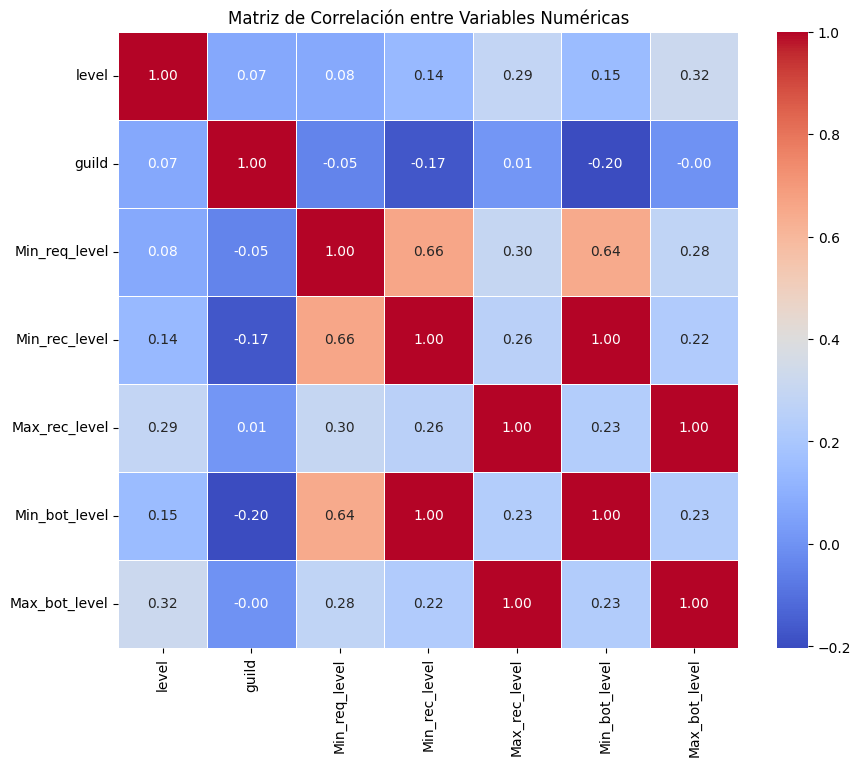

In [83]:
data_combined = pd.concat([wowah_data[['level', 'guild']], 
                           zones[['Min_req_level', 'Min_rec_level', 'Max_rec_level', 'Min_bot_level', 'Max_bot_level']]], 
                          axis=1)

correlation_matrix = data_combined.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()

Al observar la matriz de correlación, podemos identificar relaciones clave entre variables numéricas importantes, como los niveles de los jugadores y las zonas en las que se encuentran. Por ejemplo, una correlación moderada entre el nivel de los personajes y el nivel máximo recomendado de la zona podría indicar que los jugadores tienden a seguir las recomendaciones del juego en cuanto a dónde deberían estar. Por otro lado, correlaciones más bajas en otras áreas podrían sugerir que algunos jugadores se aventuran en zonas fuera de su nivel recomendado, lo que refleja una mayor flexibilidad en el estilo de juego y exploración del mundo.

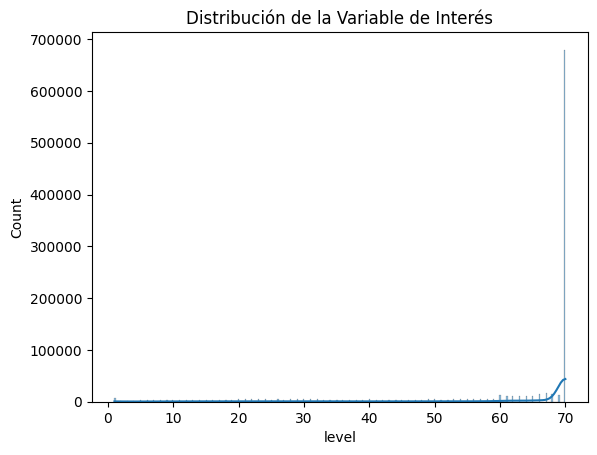

In [84]:
sns.histplot(wowah_data['level'], kde=True)
plt.title('Distribución de los niveles')
plt.show()

FASE 3 : Preparación de los datos

Ahora procederemos a configurar y perfeccionar los DataSet para nuestra conveniencia y así llegar a la solución con datos limpios y significativos.

In [106]:
wowah_data['timestamp'] = pd.to_datetime(wowah_data['timestamp'], format='%m/%d/%y %H:%M:%S')

wowah_data['timestamp'] = wowah_data['timestamp'].astype('int64') // 10**9

print(wowah_data['timestamp'].head())

[09/25/24 23:23:33] WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_15292\2387256545.py:1:     ]8;id=129544;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=175960;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

                    WARNING  C:\Users\nar_u\AppData\Local\Temp\ipykernel_15292\2387256545.py:3:     ]8;id=800022;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=495010;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

4    1199145729
5    1199145729
6    1199145734
7    1199145734
8    1199145734
Name: timestamp, dtype: int64


Cambiamos el tipo de dato de TIMESTAMP de wowah_data para trabajar con numeros y no con tipos de datos de fecha

In [ ]:
scaler = StandardScaler()
wowah_data_standardized = scaler.fit_transform(wowah_data[['level']])
normalizer = MinMaxScaler()
wowah_data_normalized = normalizer.fit_transform(wowah_data[['level']])


wowah_data_standardized_df = pd.DataFrame(wowah_data_standardized, columns=['level_standardized'])
wowah_data_normalized_df = pd.DataFrame(wowah_data_normalized, columns=['level_normalized'])

plt.figure(figsize=(10, 6))
sns.histplot(wowah_data_standardized_df['level_standardized'], kde=True, color='blue', bins=30)
plt.title('Distribución de level estandarizado')
plt.xlabel('Valor estandarizado')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(wowah_data_normalized_df['level_normalized'], kde=True, color='green', bins=30)
plt.title('Distribución de level normalizado')
plt.xlabel('Valor normalizado')
plt.ylabel('Frecuencia')
plt.show()

Primero, utilizamos StandardScaler para transformar los datos a una distribución con media 0 y desviación estándar 1. Luego, aplicamos MinMaxScaler para ajustar los valores al rango de 0 a 1. Los resultados se convierten en DataFrames para facilitar la visualización. Finalmente, se generan histogramas con seaborn para mostrar las distribuciones de los datos estandarizados y normalizados, permitiendo comparar cómo se distribuyen los niveles de los jugadores tras cada transformación.

[09/25/24 23:24:49] WARNING  C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\site-packag ]8;id=723628;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=103402;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             es\sklearn\base.py:493: UserWarning:                                                  
                                                                                                                   
                             X does not have valid feature names, but PolynomialFeatures was fitted                
                             with feature names                                                                    
                                                                                                                   
                                                                                                                   

[09/25/24 23:24:52] WARNING  C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\site-packag ]8;id=537675;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=714736;file://C:\Users\nar_u\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             es\IPython\core\pylabtools.py:170: UserWarning:                                       
                                                                                                                   
                             Creating legend with loc="best" can be slow with large amounts of                     
                             data.                                                                                 
                                                                                                                   
                                                                                                                   

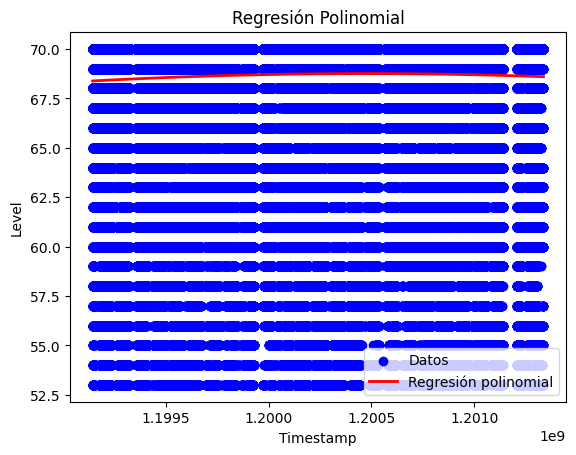

In [108]:
# Selecciona la característica y el objetivo
X = wowah_data[['timestamp']]
y = wowah_data['level']

# Crear un pipeline que incluya la generación de características polinomiales y la regresión lineal
degree = 3  # Puedes ajustar el grado del polinomio
model = make_pipeline(
  PolynomialFeatures(degree=degree, include_bias=False),
  LinearRegression()
)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicciones para la gráfica
X_plot = np.linspace(X['timestamp'].min(), X['timestamp'].max(), 100).reshape(-1, 1)
y_plot = model.predict(X_plot)

# Graficar
plt.scatter(X, y, color='blue', label='Datos')
plt.plot(X_plot, y_plot, color='red', linewidth=2, label='Regresión polinomial')
plt.xlabel('Timestamp')
plt.ylabel('Level')
plt.title('Regresión Polinomial')
plt.legend()
plt.show()

Se aplica una regresión polinomial para modelar la relación entre las variables. La línea roja representa el modelo ajustado a los datos. La gráfica muestra cómo el modelo polinomial se ajusta a los datos, capturando tendencias no lineales.

In [85]:
diccionario = {'Subzone':'None','Size':0,'Area':'None','Zone':'None','Min_rec_level':0,'Max_rec_level':0,'Min_bot_level':0,'Max_bot_level':0, }
zones = zones.fillna(diccionario)

Rellenamos los valores nulos del archivo zones, ya sea, colocando None a strings vacíos o ceros a valores numericos nulos.

In [86]:
zones['Min_rec_level'] = zones['Min_rec_level'].astype(int)
zones['Max_rec_level'] = zones['Max_rec_level'].astype(int)
zones['Min_bot_level'] = zones['Min_bot_level'].astype(int)
zones['Max_bot_level'] = zones['Max_bot_level'].astype(int)

Ahora normalizamos los numeros del archivos zones, para que podamos trabajar de mejor manera con columnas del mismo tipo de dato.

In [87]:
wowah_data['guild'] = wowah_data['guild'].replace(-1, 0)

Después normalizamos los numeros del archivos wowah_data, cambiando los numeros -1 a 0's.

In [88]:
wowah_data.columns = wowah_data.columns.str.strip()

Quitamos los espacios de las columnas del dataset para poder referirnos correctamente a las columnas que necesitemos.

In [89]:
z = np.abs(stats.zscore(wowah_data['level']))
wowah_data = wowah_data[( z < 3 )]
wowah_data

,char,level,race,charclass,zone,guild,timestamp
1,65494,9,Orc,Hunter,Durotar,0,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,0,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,0,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,0,01/01/08 00:02:09
5,2289,60,Orc,Hunter,Hellfire Peninsula,0,01/01/08 00:02:09
...,...,...,...,...,...,...,...
1048570,1094,70,Undead,Rogue,Arathi Basin,103,01/26/08 08:11:58
1048571,22703,70,Undead,Warlock,Orgrimmar,103,01/26/08 08:12:03
1048572,33016,70,Undead,Warlock,Orgrimmar,204,01/26/08 08:12:03
1048573,8245,70,Undead,Warlock,Shadowmoon Valley,19,01/26/08 08:12:03


Recortamos los outliers de wowah_data con niveles menores a 3 de la columna de level, puesto que queremos dejar lo mas representativo

Ahora procedemo a recortar los datos aun mas, sacamos los outliers de los DataFrames ( wowah_data y zones ) con la puntuación IQR y comparamos con el antes y los nuevos datos mas significativos.

In [90]:
wowah_data_antes = wowah_data
wowah_data_antes.shape

(1026942, 7)

In [91]:
Q1 = wowah_data['level'].quantile(0.25)
Q3 = wowah_data['level'].quantile(0.75)
IQR = Q3 - Q1
wowah_data = wowah_data[~((wowah_data['level'] < (Q1 - 1.5 * IQR ))|(wowah_data['level'] > (Q3 + 1.5 * IQR )))]
wowah_data.shape

(842445, 7)

In [92]:
zones_antes = zones
zones_antes.shape

(160, 13)

In [93]:
Q1 = zones['Min_rec_level'].quantile(0.25)
Q3 = zones['Min_rec_level'].quantile(0.75)
IQR = Q3 - Q1
zones = zones[~((zones['Min_rec_level'] < (Q1 - 1.5 * IQR ))|(zones['Min_rec_level'] > (Q3 + 1.5 * IQR )))]
zones.shape


(160, 13)

Primero, hacemos una copia de wowah_data para poder ver el antes y después del tamaño de los datos. Aplicamos la puntuación IQR para sacar de nuestra ecuacion aquellos datos que estan fuera de nuestros cuartiles principales. Y luego hacemos lo mismo con zones.

Todo esto de la limpieza y pulido de datos serán para que no puedan dar errores a la hora de llegar a la fase de modelar y tambien para que los resultados estén acordes a los datos mas representativos de nuestros DataSet.